In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np 
import time
import random
import os
import json
import scipy.spatial.distance
from models.rnnpb import RNNPB
from models.rnnpbnmt import RNNPBNMT
from misc.dataset import Dataset
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from matplotlib.lines import Line2D

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
checkp = "ckpt1.85-36"
working_dir = "saves/resetdropout/rnnpb50000-0.20-0.30/"

In [3]:
!ls saves/resetdropout/rnnpb50000-0.20-0.30/checkpoints/

ckpt1.85-36.data-00000-of-00002  ckpt1.85-36.index
ckpt1.85-36.data-00001-of-00002


In [4]:
data = Dataset("data/autoenc/easy50000/dev.en", "data/autoenc/easy50000/dev.en", 1, 
               vocab = os.path.join(working_dir, "vocab"), shuffle=False)

In [5]:
with open(os.path.join(working_dir, "model.json"), "r") as f:
    model_json = json.loads(f.read())

model_name = model_json["model_name"]
model_params = model_json["model_params"]

model = RNNPBNMT(vocab1_size = data.first.vocab_size, vocab2_size = data.second.vocab_size, working_dir=working_dir, **model_params)

In [6]:
ckpts = os.listdir(os.path.join(working_dir, "checkpoints"))
#ckpts.remove('checkpoint')
#ckpts = {x for x in ckpts if 'index' not in x}
#ckpts = {x.split('.data', 1)[0] for x in ckpts}
#ckpt_best = min(ckpts, key = lambda x : float(x.lstrip('ckpt').split('-')[0]))
#ckpt_newest = max(ckpts, key = lambda x : int(x.split('-')[-1]))


In [7]:
checkpoint = model.get_checkp()
checkpoint = tf.train.Checkpoint(**checkpoint)

#assert ckpt_newest is not None
#assert ckpt_best is not None

ckpt = checkp

print("Restored {} from possible {}".format(ckpt, ckpts))
checkpoint.restore(os.path.join(working_dir, "checkpoints", ckpt))

Restored ckpt1.85-36 from possible ['ckpt1.85-36.data-00000-of-00002', 'ckpt1.85-36.data-00001-of-00002', 'ckpt1.85-36.index']


In [8]:
def sentence_to_tensor(s, w2idx):
    s = [w2idx.get(w, w2idx["<UNK>"]) for w in s.split(" ")]
    x = tf.convert_to_tensor(s)
    return x

def tensor_to_sentence(x, idx2w):
    return " ".join(idx2w[i] for i in x)

def translate(A, B, x, B_idx2w, eps=0.0001, return_pb = False):
    x = tf.expand_dims(x, 0)
    
    pb = A.recognize(x, eps = eps)[0]
    y = B.generate(pb, max_length = round(1.5 * len(x[0])), start=START, end=END)
    
    s = tensor_to_sentence(y, B_idx2w)
    return (s, pb[0]) if return_pb else s


In [9]:
colors = ['red', 'blue', 'green', 'black', 'orange', 'purple', 'pink', 'gray' ,'cyan', 'magenta']
def plot_pbs(A_pbs, B_pbs, plot_zero = False):

    pb_dim = A_pbs.shape[1]

    pca = PCA(n_components = 2)
    pca.fit(np.concatenate([A_pbs, B_pbs]))

    A_pbs, B_pbs = pca.transform(A_pbs), pca.transform(B_pbs)

    for i in range(A_pbs.shape[0]):

        color = colors[i]

        for p, m in zip([A_pbs[i]],['o']):#, B_pbs[i]], ['o', 's']):
            x, y = p

            plt.scatter(x, y, c = color, marker=m)

        legend_elements = [Line2D([0], [0], marker='o', color='w', label='A and B', markerfacecolor='white', markeredgecolor='black', markersize=7)]
                           #Line2D([0], [0], marker='s', color='w', label='B', markerfacecolor='white', markeredgecolor='black', markersize=7)]
        plt.legend(handles=legend_elements)

    if plot_zero:
        z = pca.transform(np.zeros((1, pb_dim)))
        x, y = z[0]
        plt.scatter(x, y, c='black', marker='+')
    
    #plt.savefig("autotrans_binding_{}.png".format(binding), dpi=1000, bbox_inches = 'tight',
    #pad_inches = 0.1)
    plt.show()

In [10]:
examples = [row for _, row in zip(range(10), data)]

A_pbs = []
B_pbs = []
for X, X_length, Y, Y_length, ids in examples:
    _, _, A_pb = model.A(X, ids)
    A_pbs.append(A_pb[0])

    _, _, B_pb = model.B(X, ids)
    B_pbs.append(B_pb[0])

W0702 14:59:38.931618 140388777658176 deprecation.py:323] From /home/daniel/venv/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:3868: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
A = np.array(A_pbs)
B = np.array(B_pbs)

In [12]:
fig = plt.figure(num=1, figsize=(5, 5), frameon=False)
#plot_pbs(A, B, plot_zero=True)

<Figure size 360x360 with 0 Axes>

In [13]:
all_A_pbs = model.A.pb_embedding.get_weights()[0]
all_B_pbs = model.B.pb_embedding.get_weights()[0]

In [14]:
model.A.print_pb_stats()

Dist origin to centroid: 0.058784325
Mean distance from centroid: 2.4642863
Max distance from centroid: 10.937766


In [15]:
model.B.print_pb_stats()

Dist origin to centroid: 0.058784325
Mean distance from centroid: 2.4642863
Max distance from centroid: 10.937766


In [16]:
trained = np.where(np.logical_not(np.all(all_A_pbs == 0, axis = 1)))[0]

all_A_pbs = all_A_pbs[trained]
all_B_pbs = all_B_pbs[trained]

In [17]:
some_A = all_A_pbs[np.random.randint(0, all_A_pbs.shape[0], 1000)]
some_B = all_B_pbs[np.random.randint(0, all_B_pbs.shape[0], 1000)]

In [18]:
#pair_dist = np.mean(np.sqrt(np.sum((all_A_pbs - all_B_pbs) ** 2, axis=1)))
#mean_dist = np.mean(scipy.spatial.distance.cdist(some_A, some_B))

In [19]:
#print(pair_dist, mean_dist)

In [20]:
def recognize(self, X, eps = 0.0001, early_stop_steps = 3, iters = None, step = None, max_iters=500):
    X_inputs = X[:, :-1]
    X_targets = X[:, 1:]
    X_mask = 1 - np.equal(X_targets, 0)

    batch_size = X.shape[0]

    pbs = tf.Variable(tf.zeros((batch_size, self.num_PB)))

    losses = []
    n = 0

    optimizer = tfa.optimizers.LazyAdam(self.pb_lr)

    pbs_list = []
    grads = []

    stagnation_steps = 0
    best_loss = float('inf')
    while n < iters if iters is not None else stagnation_steps < early_stop_steps and n < max_iters:

        with tf.GradientTape() as tape:
            X_outputs, _, _= self(X_inputs, pbs=pbs)

            X_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = X_targets, logits=X_outputs) * X_mask
            X_loss = tf.reduce_mean(tf.reduce_sum(X_loss, axis = 1))

        variables = [pbs]
        gradients = tape.gradient(X_loss, variables)
        gradients, _ = tf.clip_by_global_norm(gradients, self.gradient_clip)
        optimizer.apply_gradients(zip(gradients, variables))

        if n % 100 == 0:
            print("Recognition iteration {} Loss {:.3f}".format(n, X_loss))

        if step is not None and n % step == 0:
            pbs_list.append(pbs.numpy())
            grads.append(float(tf.math.sqrt(tf.reduce_sum(gradients[0]**2))))

        if X_loss < best_loss - eps:
            best_loss = X_loss
            stagnation_steps = 0
        else:
            stagnation_steps += 1

        n += 1

    print("Recognition finished, iteration {} Loss {:.3f}".format(n, X_loss))

    return pbs if step is None else pbs_list, grads


def recognition_perplexities(x, x_lengths):
    B_X = x[:, :-1]
    B_Y = x[:, 1:]
    pbs, gradients = recognize(model.A, x, iters=200, step=1)
    perplexities = []
    for pb in pbs:
        
        logits, _, _ = model.B(B_X, pbs=pb)
        
        _, perplexity = model.loss(targets=B_Y, logits=logits, target_lengths=x_lengths - 1)
        
        perplexities.append(float(perplexity))
    
    return perplexities, gradients

In [21]:
finals = []
colors = ['red', 'blue', 'green', 'black', 'purple']
perps = []
grads = []
N = 256
for i, (x, x_lengths, _, _, _) in zip(range(N), data):
    perp, grad = recognition_perplexities(x, x_lengths)
    perps.append(perp)
    grads.append(grad)
    finals.append(perp[-1])
print(finals)

Recognition iteration 0 Loss 13.994
Recognition iteration 100 Loss 0.000
Recognition finished, iteration 200 Loss 0.000
Recognition iteration 0 Loss 23.024
Recognition iteration 100 Loss 0.002
Recognition finished, iteration 200 Loss 0.001
Recognition iteration 0 Loss 18.061
Recognition iteration 100 Loss 0.001
Recognition finished, iteration 200 Loss 0.001
Recognition iteration 0 Loss 23.945
Recognition iteration 100 Loss 0.001
Recognition finished, iteration 200 Loss 0.000
Recognition iteration 0 Loss 11.672
Recognition iteration 100 Loss 0.000
Recognition finished, iteration 200 Loss 0.000
Recognition iteration 0 Loss 17.115
Recognition iteration 100 Loss 0.000
Recognition finished, iteration 200 Loss 0.000
Recognition iteration 0 Loss 21.538
Recognition iteration 100 Loss 0.000
Recognition finished, iteration 200 Loss 0.000
Recognition iteration 0 Loss 18.680
Recognition iteration 100 Loss 0.000
Recognition finished, iteration 200 Loss 0.000
Recognition iteration 0 Loss 21.153
Reco

Recognition iteration 100 Loss 0.000
Recognition finished, iteration 200 Loss 0.000
Recognition iteration 0 Loss 23.680
Recognition iteration 100 Loss 0.001
Recognition finished, iteration 200 Loss 0.001
Recognition iteration 0 Loss 16.948
Recognition iteration 100 Loss 0.000
Recognition finished, iteration 200 Loss 0.000
Recognition iteration 0 Loss 15.990


KeyboardInterrupt: 

In [23]:
opt = min(range(len(perp)), key = lambda i : sum(p[i] for p in perps))
print("Optimal: ", opt)

Optimal:  83


In [29]:
print("Average perplexity: ",sum(p[opt] for p in perps)/len(perps))

Average perplexity:  2.049102010861249


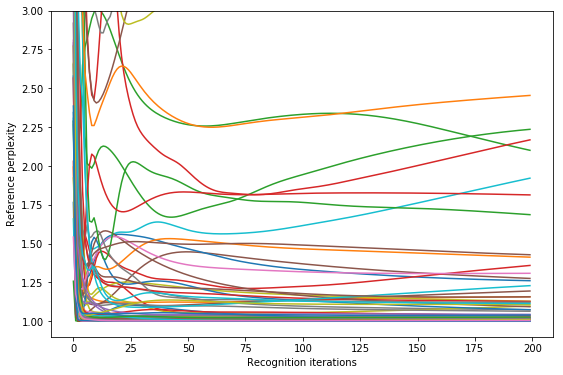

In [32]:
fig = plt.figure(num=2, figsize=(9, 6))
ax = fig.add_subplot(111)

for i in range(N):
    ax.plot(perps[i], color=colors[i])
plt.ylim(0.9, 3)
plt.xlabel("Recognition iterations")
plt.ylabel("Reference perplexity")
plt.savefig("recog_iters.png", dpi=1000, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

In [ ]:
fig = plt.figure(num=2, figsize=(9, 6))
ax = fig.add_subplot(111)

for i in range(N):
    ax.plot(perps[i][:50], color=colors[i])
    ax.plot(grads[i][:50], color=colors[i], linestyle='--')
plt.ylim(0, 3)
plt.xlabel("Recognition iterations")
plt.ylabel("Reference perplexity / gradient norm")

leg2 = [Line2D([0], [0], label='Perplexity', markersize=7, color='black'),
        Line2D([0], [0], label='Gradient norm', markersize=7, linestyle='dashed', color='black')]

ax.legend(handles=leg2, loc='upper right')

plt.savefig("recog_iters_grads.png", dpi=1000, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()